<a href="https://colab.research.google.com/github/httc805155/FacialRecognition/blob/master/EmotionModel_TsoHua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Challenges in Representation Learning: Facial Expression Recognition Challenge**

https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data?select=fer2013.tar.gz

 **Easiest way to download kaggle data in Google Colab**
 
 https://www.kaggle.com/general/74235

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#! kaggle datasets list

In [3]:
! kaggle competitions download -c 'challenges-in-representation-learning-facial-expression-recognition-challenge'

  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 8.15MB/s]
 91% 84.0M/92.0M [00:03<00:00, 19.3MB/s]
100% 92.0M/92.0M [00:03<00:00, 29.0MB/s]
 47% 9.00M/19.3M [00:00<00:00, 15.7MB/s]
100% 19.3M/19.3M [00:00<00:00, 30.4MB/s]
 94% 73.0M/77.3M [00:02<00:00, 29.0MB/s]
100% 77.3M/77.3M [00:02<00:00, 32.1MB/s]
 87% 84.0M/96.6M [00:03<00:00, 29.2MB/s]
100% 96.6M/96.6M [00:03<00:00, 31.4MB/s]


In [4]:
# Create the folder for saving data
! mkdir train
! mkdir test
! unzip train.csv.zip -d train
! unzip test.csv.zip -d test

Archive:  train.csv.zip
  inflating: train/train.csv         
Archive:  test.csv.zip
  inflating: test/test.csv           


In [5]:
import pandas as pd
import numpy as np

TrainData = pd.read_csv("./train/train.csv")
TestData = pd.read_csv("./test/test.csv")
Train_Emotion = TrainData['emotion']
Train_Image2D_str = TrainData['pixels']
FinalTest_Image2D_str = TestData['pixels']

image_size = 48
data_count = len(Train_Image2D_str)

Train_Image = np.zeros((data_count, image_size, image_size, 3))

#### show image for example
# DataArray = [int(x) for x in TrainData['pixels'][0].split(" ")]
# npDataArray = np.array(DataArray)
# img = np.reshape(npDataArray, (48,48))

# import matplotlib.pyplot as plt
# plt.imshow(img)
# plt.show()

In [6]:
# Convert input data from 1D string to 2D image_3channels
for index in range(data_count):
  ImageArray = np.array([int(x) for x in Train_Image2D_str[index].split(" ")])
  Train_Image2D = np.reshape(ImageArray, (48, 48))
  Train_Image[index] = np.stack((Train_Image2D, Train_Image2D, Train_Image2D), axis=2)


In [27]:
import tensorflow as tf
TrianDataNum = len(Train_Emotion)
unique_label, EmotinCounts = np.unique(Train_Emotion, return_counts=True)
print(unique_label)
print(EmotinCounts)

EmotinTypeNum = len(np.unique(Train_Emotion))
Emtion_OneHotEncode = tf.keras.utils.to_categorical(Train_Emotion, EmotinTypeNum, 'int16')

from sklearn.model_selection import train_test_split
Image_train, Image_test, Emotion_train, Emotion_test = train_test_split(Train_Image, Emtion_OneHotEncode, test_size=0.2, random_state=0)
print(Image_train.shape, Image_test.shape)
print(Emotion_train.shape, Emotion_test.shape)

[0 1 2 3 4 5 6]
[3995  436 4097 7215 4830 3171 4965]
(22967, 48, 48, 3) (5742, 48, 48, 3)
(22967, 7) (5742, 7)


In [ ]:
# Process inbalanced data

In [ ]:
### Using transfer learning
# input of ResNet should have 3 inputs channels,
# and width and height should be no smaller than 32
Model_ResNet50V2 = tf.keras.applications.resnet_v2.ResNet50V2(
      include_top=False, 
      weights='imagenet', 
      input_tensor=None,
      input_shape=(image_size, image_size, 3), 
      pooling=None, 
      classes=EmotinTypeNum,
      classifier_activation='softmax'
)

x = Model_ResNet50V2.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
predictions = tf.keras.layers.Dense(EmotinTypeNum, activation='softmax')(x)
model = tf.keras.Model(Model_ResNet50V2.input, predictions)

model.summary()

# Preprocessing for the selected model
Image_train = tf.keras.applications.resnet_v2.preprocess_input(Image_train)
Image_test = tf.keras.applications.resnet_v2.preprocess_input(Image_test)


In [ ]:
#include_top: 表示是否完整保留Model的最後3層dense層，包含原先weights挑選的分類數量(Ex.選'imagenet'，classes會固定1000)

Model_VGG19 = tf.keras.applications.vgg19.VGG19(
    include_top=False, 
    weights='imagenet', 
    #input_tensor=None,
    input_shape=(image_size, image_size, 3), 
    #pooling=None, 
    #classes=EmotinTypeNum,
    #classifier_activation='softmax'
)

### Consider if we want to change the the last 3 dense layers.

model.summary()

### Preprocessing for the selected model
Image_train = tf.keras.applications.vgg19.preprocess_input(Image_train)
Image_test = tf.keras.applications.vgg19.preprocess_input(Image_test)

In [28]:
### The time using VGG19 and ResNet50 was too long to train on colab
model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3)),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same'),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same'),
      tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(EmotinTypeNum, activation='softmax'),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
activation_14 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 64)       

In [29]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# EarlyStop
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5',
                              monitor='val_loss', 
                              save_weights_only=False, 
                              save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

In [30]:
# Train model
logs = model.fit(Image_train, Emotion_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          callbacks=[early_stopping, reduce_lr, checkpoint],     
          validation_data=(Image_test, Emotion_test))

Epoch 1/20
718/718 [==============================] - 381s 529ms/step - loss: 1.6597 - accuracy: 0.3353 - val_loss: 1.9014 - val_accuracy: 0.3090
Epoch 2/20
718/718 [==============================] - 380s 530ms/step - loss: 1.3953 - accuracy: 0.4692 - val_loss: 1.6691 - val_accuracy: 0.4002
Epoch 3/20
718/718 [==============================] - 378s 526ms/step - loss: 1.2727 - accuracy: 0.5207 - val_loss: 1.5447 - val_accuracy: 0.3729
Epoch 4/20
718/718 [==============================] - 379s 527ms/step - loss: 1.2054 - accuracy: 0.5425 - val_loss: 1.3470 - val_accuracy: 0.4756
Epoch 5/20
718/718 [==============================] - 382s 533ms/step - loss: 1.1418 - accuracy: 0.5659 - val_loss: 1.5801 - val_accuracy: 0.3952
Epoch 6/20
718/718 [==============================] - 380s 529ms/step - loss: 1.0822 - accuracy: 0.5907 - val_loss: 2.2615 - val_accuracy: 0.2950
Epoch 7/20
718/718 [==============================] - 380s 529ms/step - loss: 1.0354 - accuracy: 0.6079 - val_loss: 1.8488 -

Text(0.5, 1.0, 'accuracy')

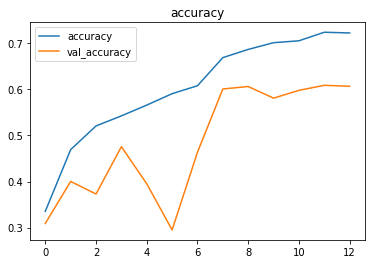

In [33]:
import matplotlib.pyplot as plt
history = logs.history

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

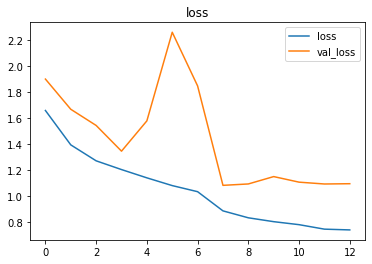

In [34]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')